# Exploring Airbnb listings and pricing in the Greater Montréal Area
## Business Understanding and Defining objectives ( Step 1 of CRISP-DM):

In this notebook, we will be answering the below Questions about Airbnb market in Montréal, QC, Canada. This might help potential holiday seekers in having better understanding how easy is it to find listings and certain types of listings in the different Great Montreal neighbourhoods and have a general understanding of listing types based on their needs. 

* What is the percentage of listings per neighbourhood?
* What is the distribution of the different listing types?
* How much does it cost to rent an Entire home or apartment vs a private room?

The listings percentage by location gives visitors of the ease of finding listings in connected central neighbourhoods. The listing type distribution is helpful for those who are traveling with others particulary families, and how easy it is to find accommodation. The cost is useful for the obvious reasons. 

**Important Note:**

The CRISP-DM is not a necessarily a linear process; there would definitely a back and forth particulary between the data exploration, data preparation and data modeling. 
In this case we will go over a general step then delve futher to answer the posed questions.
https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/lifecycle-business-understanding

Remidner of the CRISP-DM steps:
- Business Understanding
- Data Understanding
- Prepare Data
- Data Modeling
- Evaluate the Results

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from pathlib import Path
import requests 
from IPython.display import display
%matplotlib inline

**Acquiring the Airbnb dataset from source**

Download the datasets needed from source if they are not already there. 

In [5]:
# download data to project folder listings.csv.gz
# This will create a subfolder where this notebook is installed and download the file.

data_src = 'listings.csv.gz'
url= 'http://data.insideairbnb.com/canada/qc/montreal/2020-03-17/data/listings.csv.gz'

def download_url(url, save_path, chunk_size=256):
    """
    Check if file already exists, if not use url to download it.
    Args:
        url(str): URL of the zipped file.
        save_path(str): Path where the file should be saved
        chunk_size(int): Chunk size to iterate over from the streamed request.
    """
    # check if file exists at path or not
    if not Path(save_path).exists():
        r = requests.get(url, stream=True)
        with open(save_path, 'wb') as fd:
            for chunk in r.iter_content(chunk_size=chunk_size):
                fd.write(chunk)

# Download from url if file doesn't exist.
download_url(url, data_src)

    
# Display all columns to have an understanding of the feature vectors provided. 
pd.options.display.max_columns = None

## General Understanding of the data (Step 2 of the CRISP-DM)

In [6]:
# Read the compressed csv file to a pandas dataframe. This is in a separate cell as to run it once.
df = pd.read_csv(data_src, compression='gzip', error_bad_lines=False)
df.head(5)

/Users/faisalbarazi/projects/airbnb_mtl_prices/airbnb_mtl_venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2078,https://www.airbnb.com/rooms/2078,20200317175912,2020-03-18,Central comfy close to Metro Laurie,Centrally located in trendy Le Plateau. Join...,Centrally located clean comfy furnished room ...,Centrally located in trendy Le Plateau. Join...,none,Although my place is centrally located in Le P...,I always inform my guests the places/attractio...,I am 6-8 mins. walk to Metro Laurie and bus ro...,You will have full access in the apartment. I...,I am always available to help and give informa...,No house rules but I expect my guests to follo...,NaN,NaN,https://a0.muscache.com/im/pictures/88170231/0...,NaN,2277,https://www.airbnb.com/users/show/2277,Nelia,2008-08-19,"Montreal, Québec, Canada","Honest, quiet and adhere to the golden rules a...",within an hour,100%,0%,f,https://a0.muscache.com/im/users/2277/profile_...,https://a0.muscache.com/im/users/2277/profile_...,Le Plateau,1.0,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Montreal, QC, Canada",Le Plateau-Mont-Royal,Le Plateau-Mont-Royal,NaN,Montreal,QC,H2J 3E9,Montreal,"Montreal, Canada",CA,Canada,45.53069,-73.58588,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,Kitchen,""Pets live on this prop...",NaN,$39.00,$190.00,NaN,$0.00,$0.00,1,$6.00,2,7,2,2,7,7,2.0,7.0,2 weeks ago,t,0,0,0,76,2020-03-18,245,0,2011-09-06,2018-09-23,93.0,10.0,9.0,10.0,10.0,10.0,10.0,f,NaN,"{Quebec,"" CA""}",t,f,flexible,f,f,1,0,1,0,2.36
1,2843,https://www.airbnb.com/rooms/2843,20200317175912,2020-03-18,Fabulous downtown/airport room,Come stay in this trendy area of downtown Mont...,"Private individual room in the downtown area, ...",Come stay in this trendy area of downtown Mont...,none,This area of St Henri is actually downtown Mon...,From this room you can walk to downtown Montre...,There is a major metro/subway stop called Lion...,"The guests can use the kitchen anytime, fully ...",I meet guests when they arrive show them the h...,No smoking and no pets Airport bus stops acros...,NaN,NaN,https://a0.muscache.com/im/pictures/397204dc-4...,NaN,2319,https://www.airbnb.com/users/show/2319,Gail,2008-08-19,"Montreal, Québec, Canada",Manage a network of downtown rooms and private...,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/7c04e...,https://a0.muscac

The data shows listings in the Greater Montreal Area. Of these columns, certain infromation doesn't help us in answering the questions; these with long texts, image urls ... etc. 
Further there is redundant information that we can reduce; the number of listings and the total number of listings for example. We will continue by removing the obvious columns that need to be removed and do general cleaning on the dataset.

## General preparation of the data (Step 3 of CRISP-DM)
Here we will:
* Remove columns that are deemed unnecessary to answer the above mentioned questions.
* Drop all the columns that are empty or have a high percentage of empty values(more than 80%).
* Fill or drop values that doesn't make sense (0 accomodations, 0% host response etc). 
* Make sure that the datatypes are in the right type, else update these to make use of the data.



In [7]:
# drop empty columns inplace in the same cell and get the names of the dropped columns
num_features_before = set(df.columns)
df.dropna(how='all',axis=1,inplace=True)
num_features_after = set(df.columns)

print(f'Dropped columns are: {(num_features_before - num_features_after)}')

Dropped columns are: {'neighbourhood_group_cleansed', 'license', 'xl_picture_url', 'thumbnail_url', 'medium_url'}


In [8]:
# Explore the dataset a bit
df.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2078,https://www.airbnb.com/rooms/2078,20200317175912,2020-03-18,Central comfy close to Metro Laurie,Centrally located in trendy Le Plateau. Join...,Centrally located clean comfy furnished room ...,Centrally located in trendy Le Plateau. Join...,none,Although my place is centrally located in Le P...,I always inform my guests the places/attractio...,I am 6-8 mins. walk to Metro Laurie and bus ro...,You will have full access in the apartment. I...,I am always available to help and give informa...,No house rules but I expect my guests to follo...,https://a0.muscache.com/im/pictures/88170231/0...,2277,https://www.airbnb.com/users/show/2277,Nelia,2008-08-19,"Montreal, Québec, Canada","Honest, quiet and adhere to the golden rules a...",within an hour,100%,0%,f,https://a0.muscache.com/im/users/2277/profile_...,https://a0.muscache.com/im/users/2277/profile_...,Le Plateau,1.0,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Montreal, QC, Canada",Le Plateau-Mont-Royal,Le Plateau-Mont-Royal,Montreal,QC,H2J 3E9,Montreal,"Montreal, Canada",CA,Canada,45.53069,-73.58588,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,Kitchen,""Pets live on this prop...",NaN,$39.00,$190.00,NaN,$0.00,$0.00,1,$6.00,2,7,2,2,7,7,2.0,7.0,2 weeks ago,t,0,0,0,76,2020-03-18,245,0,2011-09-06,2018-09-23,93.0,10.0,9.0,10.0,10.0,10.0,10.0,f,"{Quebec,"" CA""}",t,f,flexible,f,f,1,0,1,0,2.36
1,2843,https://www.airbnb.com/rooms/2843,20200317175912,2020-03-18,Fabulous downtown/airport room,Come stay in this trendy area of downtown Mont...,"Private individual room in the downtown area, ...",Come stay in this trendy area of downtown Mont...,none,This area of St Henri is actually downtown Mon...,From this room you can walk to downtown Montre...,There is a major metro/subway stop called Lion...,"The guests can use the kitchen anytime, fully ...",I meet guests when they arrive show them the h...,No smoking and no pets Airport bus stops acros...,https://a0.muscache.com/im/pictures/397204dc-4...,2319,https://www.airbnb.com/users/show/2319,Gail,2008-08-19,"Montreal, Québec, Canada",Manage a network of downtown rooms and private...,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/7c04e...,https://a0.muscache.com/im/pictures/user/7c04e...,Little Burgundy,6.0,6.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",

Since we already now that we are looking at datasets from Montréal, info about state or city are not useful. 
Some information cannot be as well easily 'quantified' such as summaries and notes.
We can as well remove the columns that we think are not helpful in answering the above stated questions to make it lighter to deal with the dataset and eaiser to explore.

In [9]:
# Further clean up the dataframe by droping un-useful data. 
columns_to_drop = [
    'state', 'city', 'neighbourhood', 'street', 'host_picture_url','host_thumbnail_url',
    'host_about', 'host_location','host_url' ,'host_id', 'picture_url','house_rules',
    'access', 'interaction', 'notes', 'neighborhood_overview', 'description', 'space',
    'scrape_id', 'listing_url','id','transit','experiences_offered','summary','host_name',
    'host_neighbourhood', 'smart_location','country_code','country','market','amenities',
    'jurisdiction_names','last_scraped','calendar_updated','availability_30',
    'availability_60', 'availability_90','availability_365','name','zipcode','host_listings_count',
    'host_verifications','require_guest_profile_picture','require_guest_phone_verification'
]
df.drop(columns=columns_to_drop,axis=1, inplace=True,)


In [10]:
df.head(5)

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2008-08-19,within an hour,100%,0%,f,1.0,t,t,Le Plateau-Mont-Royal,45.53069,-73.58588,t,House,Private room,2,1.0,1.0,1.0,Real Bed,NaN,$39.00,$190.00,NaN,$0.00,$0.00,1,$6.00,2,7,2,2,7,7,2.0,7.0,t,2020-03-18,245,0,2011-09-06,2018-09-23,93.0,10.0,9.0,10.0,10.0,10.0,10.0,f,t,f,flexible,1,0,1,0,2.36
1,2008-08-19,within an hour,100%,100%,f,6.0,t,t,Le Sud-Ouest,45.48496,-73.58001,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,$30.00,$245.00,$650.00,$134.00,$25.00,1,$10.00,1,365,1,1,365,365,1.0,365.0,t,2020-03-18,143,29,2009-06-20,2019-12-30,88.0,9.0,9.0,9.0,9.0,10.0,10.0,f,t,f,moderate,6,3,3,0,1.09
2,2009-11-25,within a few hours,90%,74%,t,1.0,t,t,Le Plateau-Mont-Royal,45.54135,-73.57814,f,Loft,Entire home/apt,4,1.0,1.0,1.0,Real Bed,0.0,$175.00,$950.00,"$3,000.00",$200.00,$0.00,2,$20.00,3,1125,3,3,1125,1125,3.0,1125.0,t,2020-03-18,175,30,2011-06-06,2020-03-01,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,f,strict_14_with_grace_period,1,1,0,0,1.64
3,2010-05-14,within an hour,100%,99%,t,2.0,t,t,Ville-Marie,45.51939,-73.56482,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,NaN,$80.00,NaN,NaN,$0.00,$75.00,2,$15.00,2,60,2,2,60,60,2.0,60.0,t,2020-03-18,324,48,2010-06-20,2020-03-08,94.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,f,moderate,2,2,0,0,2.73
4,2010-05-14,within an hour,100%,99%,t,2.0,t,t,Ville-Marie,45.51929,-73.56493,t,House,Entire home/apt,5,1.0,2.0,2.0,Real Bed,NaN,$145.00,NaN,NaN,$0.00,$120.00,2,$20.00,3,21,3,3,21,21,3.0,21.0,t,2020-03-18,66,21,2012-02-23,2020-02-17,92.0,10.0,9.0,9.0,9.0,10.0,9.0,f,t,f,moderate,2,2,0,0,0.67


Here lets look further at the percentage of missing data for each column. At this 'general' stage, we can drop certain columns that are scarce/has a lot of missing values.

In [11]:
def missing_percentage(df):
    """
    Finds percentage of missing values in dataframe.
    returns a dataframe with these percentages
    """
    
    missing = 1 - df.count()/len(df)
    missing = missing.reset_index()
    missing.rename(columns={'index': 'column', 0: 'missing_perc'},inplace=True)
    missing.sort_values('missing_perc', axis=0, ascending=False, inplace=True)
    return missing.T

missing = missing_percentage(df)
missing

,19,22,21,2,1,23,3,24,47,46,44,43,42,45,41,39,40,56,17,16,15,0,7,6,5,4,20,48,9,8,49,11,50,51,52,53,54,55,10,12,18,30,14,25,26,27,13,29,31,38,32,33,34,35,36,37,28
column,square_feet,monthly_price,weekly_price,host_response_rate,host_response_time,security_deposit,host_acceptance_rate,cleaning_fee,review_scores_value,review_scores_location,review_scores_checkin,review_scores_cleanliness,review_scores_accuracy,review_scores_communication,review_scores_rating,first_review,last_review,reviews_per_month,beds,bedrooms,bathrooms,host_since,host_identity_verified,host_has_profile_pic,host_total_listings_count,host_is_superhost,price,requires_license,latitude,neighbourhood_cleansed,instant_bookable,is_location_exact,is_business_travel_ready,cancellation_policy,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,longitude,property_type,bed_type,maximum_minimum_nights,accommodates,guests_included,extra_people,minimum_nights,room_type,minimum_minimum_nights,minimum_maximum_nights,number_of_reviews_ltm,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,calendar_last_scraped,number_of_reviews,maximum_nights
missing_perc,0.988253,0.903896,0.888283,0.397998,0.397998,0.337778,0.278697,0.238452,0.218973,0.218725,0.218577,0.218279,0.218279,0.21818,0.217437,0.198305,0.198305,0.198305,0.00718676,0.00158604,0.0012391,0.000198255,0.000198255,0.000198255,0.000198255,0.000198255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Since most of the values in square_feet, monthly_price and weekly_price are missing, We can likely drop these safely. As square_feet is likely to play a role in pricing, will keep this for now and drop the other 2.

In [12]:
df.drop(columns=['monthly_price','weekly_price'],inplace=True)

In [13]:
df.head(5)

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2008-08-19,within an hour,100%,0%,f,1.0,t,t,Le Plateau-Mont-Royal,45.53069,-73.58588,t,House,Private room,2,1.0,1.0,1.0,Real Bed,NaN,$39.00,$0.00,$0.00,1,$6.00,2,7,2,2,7,7,2.0,7.0,t,2020-03-18,245,0,2011-09-06,2018-09-23,93.0,10.0,9.0,10.0,10.0,10.0,10.0,f,t,f,flexible,1,0,1,0,2.36
1,2008-08-19,within an hour,100%,100%,f,6.0,t,t,Le Sud-Ouest,45.48496,-73.58001,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,$30.00,$134.00,$25.00,1,$10.00,1,365,1,1,365,365,1.0,365.0,t,2020-03-18,143,29,2009-06-20,2019-12-30,88.0,9.0,9.0,9.0,9.0,10.0,10.0,f,t,f,moderate,6,3,3,0,1.09
2,2009-11-25,within a few hours,90%,74%,t,1.0,t,t,Le Plateau-Mont-Royal,45.54135,-73.57814,f,Loft,Entire home/apt,4,1.0,1.0,1.0,Real Bed,0.0,$175.00,$200.00,$0.00,2,$20.00,3,1125,3,3,1125,1125,3.0,1125.0,t,2020-03-18,175,30,2011-06-06,2020-03-01,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,f,strict_14_with_grace_period,1,1,0,0,1.64
3,2010-05-14,within an hour,100%,99%,t,2.0,t,t,Ville-Marie,45.51939,-73.56482,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,NaN,$80.00,$0.00,$75.00,2,$15.00,2,60,2,2,60,60,2.0,60.0,t,2020-03-18,324,48,2010-06-20,2020-03-08,94.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,f,moderate,2,2,0,0,2.73
4,2010-05-14,within an hour,100%,99%,t,2.0,t,t,Ville-Marie,45.51929,-73.56493,t,House,Entire home/apt,5,1.0,2.0,2.0,Real Bed,NaN,$145.00,$0.00,$120.00,2,$20.00,3,21,3,3,21,21,3.0,21.0,t,2020-03-18,66,21,2012-02-23,2020-02-17,92.0,10.0,9.0,9.0,9.0,10.0,9.0,f,t,f,moderate,2,2,0,0,0.67


To further prepare the Data we are going to transform the types of certain columns to better extract information and insight from them.

In [14]:
# Functions to clean the data
def prices_to_float(value):
    """Transform price from object to a float after cleaning it."""
    if value:
        value = str(value).replace('$','')
        value = value.replace(',','')
        value = float(value)
        return value

def bool_str_to_int(value):
    """
    Transform boolean values represented as 'f'/'t' string to an integer of 0/1
    representing a boolean value.
    """
    if value == 'f':
        return int(0)
    else:
        return int(1)

def percentage_to_float(value):
    """Transform percentage to a float after cleaning it and striping the '%' symbol."""
    value = str(value).strip('%')
    return float(value)


def update_dtype(df, clmns_list, func):
    """
    Transforms the dtype of a list of columns by applying a function to these.
    Args:
        df(DataFrame): A pandas dataframe.
        clmns_list(list): List of column names to update.
        func(function): A function that gets applied to the list of columns.
    
    Returns:
        Void - Updates the dataframe in-place.
        
    
    """
    for clmn in clmns_list:
        df[clmn] = df[clmn].apply(func)


In [15]:
# Update prices dtype to float
clmns_prices = ['price','security_deposit','cleaning_fee','guests_included','extra_people']
update_dtype(df, clmns_prices, prices_to_float)

# Update percentage
clmns_percentage = ['host_response_rate', 'host_acceptance_rate']
update_dtype(df, clmns_percentage, percentage_to_float)

# Update boolean string to float
bool_clmns = [
    'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified','is_location_exact',
    'requires_license', 'instant_bookable','is_business_travel_ready','has_availability']
update_dtype(df, bool_clmns, bool_str_to_int)
df.head(5)

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2008-08-19,within an hour,100.0,0.0,0,1.0,1,1,Le Plateau-Mont-Royal,45.53069,-73.58588,1,House,Private room,2,1.0,1.0,1.0,Real Bed,NaN,39.0,0.0,0.0,1.0,6.0,2,7,2,2,7,7,2.0,7.0,1,2020-03-18,245,0,2011-09-06,2018-09-23,93.0,10.0,9.0,10.0,10.0,10.0,10.0,0,1,0,flexible,1,0,1,0,2.36
1,2008-08-19,within an hour,100.0,100.0,0,6.0,1,1,Le Sud-Ouest,45.48496,-73.58001,1,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,30.0,134.0,25.0,1.0,10.0,1,365,1,1,365,365,1.0,365.0,1,2020-03-18,143,29,2009-06-20,2019-12-30,88.0,9.0,9.0,9.0,9.0,10.0,10.0,0,1,0,moderate,6,3,3,0,1.09
2,2009-11-25,within a few hours,90.0,74.0,1,1.0,1,1,Le Plateau-Mont-Royal,45.54135,-73.57814,0,Loft,Entire home/apt,4,1.0,1.0,1.0,Real Bed,0.0,175.0,200.0,0.0,2.0,20.0,3,1125,3,3,1125,1125,3.0,1125.0,1,2020-03-18,175,30,2011-06-06,2020-03-01,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,strict_14_with_grace_period,1,1,0,0,1.64
3,2010-05-14,within an hour,100.0,99.0,1,2.0,1,1,Ville-Marie,45.51939,-73.56482,1,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,NaN,80.0,0.0,75.0,2.0,15.0,2,60,2,2,60,60,2.0,60.0,1,2020-03-18,324,48,2010-06-20,2020-03-08,94.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,moderate,2,2,0,0,2.73
4,2010-05-14,within an hour,100.0,99.0,1,2.0,1,1,Ville-Marie,45.51929,-73.56493,1,House,Entire home/apt,5,1.0,2.0,2.0,Real Bed,NaN,145.0,0.0,120.0,2.0,20.0,3,21,3,3,21,21,3.0,21.0,1,2020-03-18,66,21,2012-02-23,2020-02-17,92.0,10.0,9.0,9.0,9.0,10.0,9.0,0,1,0,moderate,2,2,0,0,0.67


Let us look at the max, min,median and quantiles of the quantitative data.

**Note**: Back to CRISP-DM step 2, re-exploring the data and forming a better understanding of it.

In [16]:
df.describe()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,12146.000000,14553.000000,20176.000000,20172.000000,20176.000000,20176.000000,20176.000000,20176.000000,20176.000000,20176.000000,20151.000000,20144.000000,20031.000000,237.000000,20176.000000,13361.000000,15365.000000,20176.000000,20176.000000,20176.000000,20176.000000,20176.000000,20176.000000,20176.000000,20176.000000,20176.000000,20176.000000,20176.0,20176.000000,20176.000000,15789.000000,15772.000000,15772.000000,15766.000000,15774.000000,15763.000000,15758.000000,20176.000000,20176.000000,20176.0,20176.000000,20176.000000,20176.000000,20176.000000,16175.000000
mean,94.095422,85.601319,0.191862,13.209697,0.995936,0.318497,45.515823,-73.589155,0.838323,3.557891,1.154384,1.417941,1.849683,621.248945,114.639076,300.410224,55.669444,1.835845,11.220410,9.673771,826.305115,8.725218,10.573454,878.866376,881.767793,9.829679,880.549554,1.0,23.592486,9.636598,93.554437,9.609181,9.319237,9.736902,9.716305,9.673920,9.426196,0.000099,0.450238,0.0,6.353985,5.444489,0.781176,0.096501,1.367746
std,17.193358,24.682412,0.393775,79.282379,0.063623,0.465905,0.031458,0.042650,0.368164,2.453214,0.524828,1.050253,1.532448,1621.273258,223.844398,487.498385,57.695440,1.699833,21.175039,88.918571,9989.901386,33.616818,89.351153,9988.342881,9988.208815,67.953060,9988.248330,0.0,46.883489,17.964066,8.946320,0.840489,1.085340,0.761868,0.777932,0.687682,0.922444,0.009956,0.497530,0.0,17.024542,17.002036,2.245622,1.511642,1.774375
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.404540,-73.964380,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.010000
25%,99.000000,83.000000,0.000000,1.000000,1.000000,0.000000,45.497485,-73.602940,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,49.000000,0.000000,25.000000,1.000000,0.000000,1.000000,40.000000,1.000000,1.000000,65.000000,89.000000,1.000000,89.000000,1.0,1.000000,0.000000,91.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.000000,0.000000,0.0,1.000000,1.000000,0.000000,0.000000,0.180000
50%,100.000000,98.000000,0.000000,1.000000,1.000000,0.000000,45.518940,-73.579455,1.000000,3.000000,1.000000,1.000000,1.000000,200.000000,79.000000,200.000000,50.000000,1.000000,0.000000,2.000000,1125.000000,2.000000,2.000000,1125.000000,1125.000000,2.000000,1125.000000,1.0,5.000000,1.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,0.000000,0.0,1.000000,1.000000,0.000000,0.000000,0.640000
75%,100.000000,100.000000,0.000000,4.000000,1.000000,1.000000,45.533740,-73.565898,1.000000,4.000000,1.000000,2.000000,2.000000,900.000000,120.000000,450.000000,75.000000,2.000000,20.000000,4.000000,1125.000000,4.000000,5.000000,1125.000000,1125.000000,4.200000,1125.000000,1.0,23.000000,11.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,1.000000,0.0,3.000000,2.000000,

Notice that the minimum host response is 0% which raises a red flag for some entries. Having 0 bathrooms as well does.

Further the _max price_ is very high for a one night (more than 13000$), so is the max cleaning fee and deposit.

We can explore these further when looking at the prices



## Evaluating the Results (Step 5 of CRISP-DM)

###  What is the percentage of listings per neighbourhood?

This helps in understanding where most of the availabilities are in Montréal and helps us to better understand if it is easy to find something in a well connected area.

Since we will be looking at the listing distribution percentage wise in relation to neighbourhoods, lets confirm that there are no missing data here. We will do some data preparation along the way as needed.

In [17]:
# Check for null values in the neighbourhood_cleansed.count() ignores nan values, 
# so if division is 1.0 there is no missing values
df['neighbourhood_cleansed'].count()/len(df['neighbourhood_cleansed'])

1.0

As we see above, there are no missing data so we can proceed with using basic statistics.

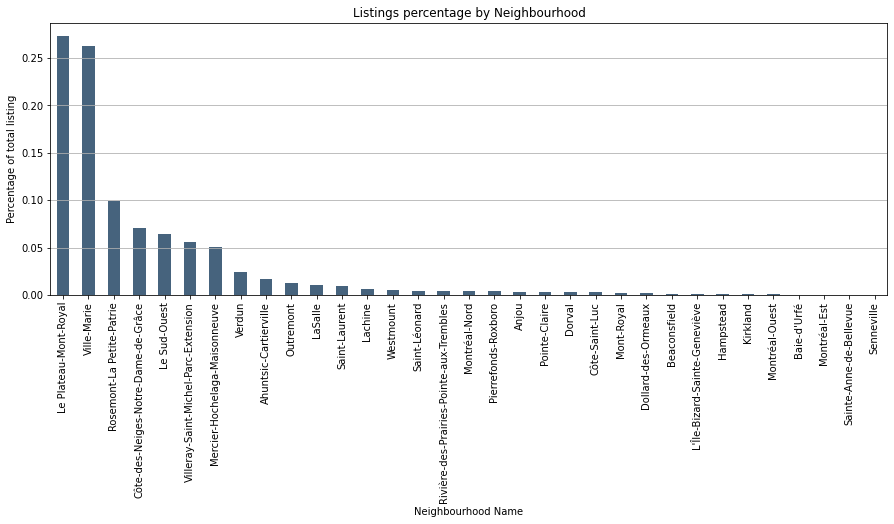

In [18]:
# Get listings by neighbourhood
cat_nhood = df['neighbourhood_cleansed'].value_counts()
cat_nhood_perc = cat_nhood/df.shape[0]

cat_nhood_plot = cat_nhood_perc.plot(kind="bar",figsize=(15,5),
                                            color='#46637D',
                                           title ="Listings percentage by Neighbourhood");
cat_nhood_plot.set_xlabel('Neighbourhood Name')
cat_nhood_plot.set_ylabel('Percentage of total listing')
cat_nhood_plot.grid('off', axis='y' )

### Conclusion
We can see from the daigram above that 2 neighbourhoods account for more than 50% of the listings in Montréal. These 2 are central areas that are well serviced by public transportation.
In fact, the first 4 neighbourhoods are central in Montréal and well served by public transportation. We can generally say that is relatively 'easy' to find listings that are central and well connected.

### What is the distribution of the different listing types?
Here we will be looking at the different distributions of listings types, this will give us idea how much family/couples the listings are. We will look at the overall distribtuion and that of the 3 major neighbourhoods.

Let's look at the room types if there are any missing data as well and if it requires transformation and preparation.

In [19]:
# Check for missing data. If answer is 1.0, there is no missing data.
df['room_type'].count()/len(df['room_type'])


1.0

In [20]:
room_type = df['room_type'].value_counts()
room_type

Entire home/apt    14311
Private room        5604
Shared room          201
Hotel room            60
Name: room_type, dtype: int64

Here were are looking at simple statistics for the overall number of listings and each of the top 3 neighbourhoods.


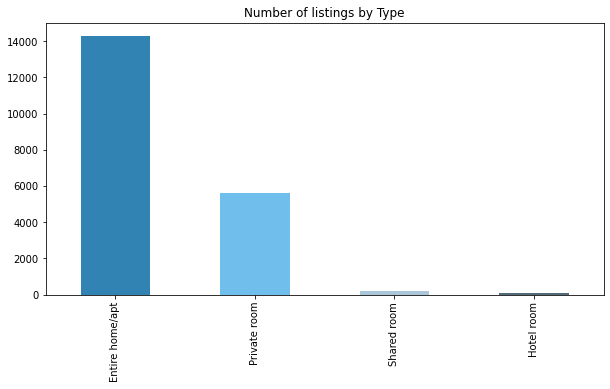

In [21]:
room_type_plot = room_type.plot(kind="bar",figsize=(10,5),
                                            color=['#3083B3','#70BEEB','#A9C7D9','#526B7A'], title ="Number of listings by Type"
)

To better understand the distribution let's look at a pie chart of the percentages for each type.

Text(0, 0.5, 'Room Type')

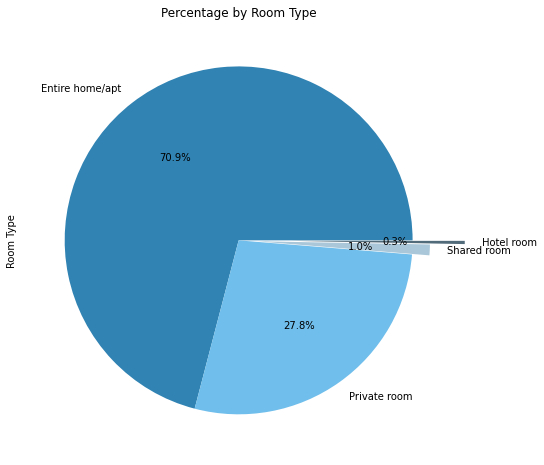

In [22]:
room_type_perc = room_type/df.shape[0]
room_type_pie = room_type_perc.plot.pie(figsize=(8,8),autopct='%1.1f%%',
                                        explode=(0, 0, 0.1,0.3),colors = ['#3083B3','#70BEEB','#A9C7D9','#526B7A'],
                                        title='Percentage by Room Type'
                                       )
room_type_pie.set_ylabel('Room Type')


We are going to look further into the 3 major neighbourhoods and the listings number for each type.

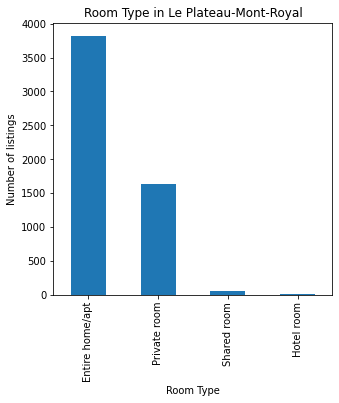

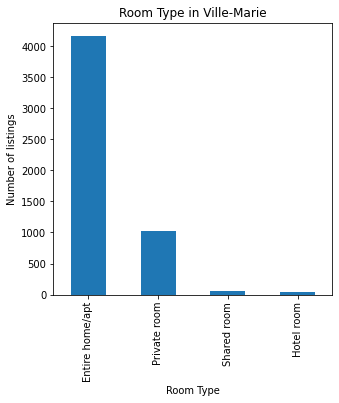

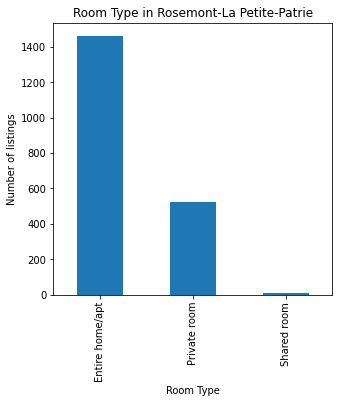

In [23]:
def plot_room_type_nhood(nhood_list):
    """Plots the number of units of each type for the first major neihbourhoods."""
    for nhood in nhood_list:
        df_major_nhood = df[
            df['neighbourhood_cleansed'].isin(
            [nhood]
            ) 
        ]
        x = df_major_nhood['room_type'].value_counts().reset_index()
        x.rename(columns={'index': 'room_type', 'room_type': 'count'}, inplace=True)
        x.set_index('room_type',inplace=True)
        plot = x.plot(kind='bar',legend=None,title=f'Room Type in {nhood}',figsize=(5,5))
        plot.set_xlabel('Room Type')
        plot.set_ylabel('Number of listings')

plot_room_type_nhood(['Le Plateau-Mont-Royal', 'Ville-Marie', 'Rosemont-La Petite-Patrie'])

### Conclusion
We can see that there is a very high percentage of listings for an Entire home/apt in the major central neighbourhoods. This could be a good news for those traveling particularly with a family that they can find an Entire home in a central well connected area. 



### What does the prices look like in Montreal for each room type?

Here we will be looking at the prices for the 2 major types; private room and entire house/apartment. This is to have an understanding of what is an Expected price for each type. Note that expectation here is not refering necessarily to the average as this might not be a good indicator given the data.

In [24]:
# Copy dataframe to manipulate it further
df_pred = df.copy()

Lets revisit  the prices and look at its distribution; its PDF. This will allow us to better understand it and take a look at outliers.
But first we will copy the original data in case we want to tranform, manipulate it further.

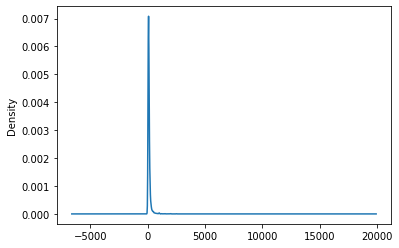

In [25]:
df_pred['price'].plot.kde()

There is likely some outliers.We can look at some extreme case for example.

In [26]:
x = df_pred['price'].max()
# out of curiosity, what is 13295$ charged on
df[df['price']== x]


,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
66,2011-05-29,NaN,NaN,0.0,0,2.0,1,1,Le Plateau-Mont-Royal,45.52023,-73.57075,1,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,13295.0,6647.0,4121.0,1.0,398.0,99,9999,99,99,9999,9999,99.0,9999.0,1,2020-03-18,1,0,2011-08-13,2011-08-13,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,strict_14_with_grace_period,1,0,1,0,0.01


Cleaning fee for '4121' and a security deposit of '6647'. Seems like 'price' in certain cases is showing some weird numbers.
This particular instance is a host since 2011, who is supposedly verified (including an actual ID face match, since jumio is an IDaaS). However they have 0% host acceptance rate. 

We can prepare the data to remove hosts with host_acceptance_rate of 0% and remove entries with 0 bathrooms (as these are red flags).


We will reduce the vectors/features to those that are most likely to affect the price. 

**NOTE:** This is an iterative process between preparing and exploring. We need these back and forth between the 2 before jumping to conclusions.

In [27]:
#copy over the main dataframe and do some visualization to check some values. 
df_pred = df_pred[
    ['host_is_superhost','host_total_listings_count',
    'neighbourhood_cleansed', 
    'room_type', 'accommodates',
    'bathrooms', 'bedrooms', 'beds', 'square_feet', 'price',
    'minimum_nights', 'maximum_nights',
    'number_of_reviews', 'review_scores_rating', 
    'is_business_travel_ready', 'reviews_per_month',
    'host_response_rate', 'host_acceptance_rate']
]
df_pred.shape

(20176, 18)


Let's remove columns with 0 host acceptance rate and 0 bathrooms. That should clean some of the entries that don't make sense.

In [28]:
df_pred = df_pred[df_pred['host_acceptance_rate']>0]
df_pred = df_pred[df_pred['bathrooms']>0]
df_pred.shape

(13984, 18)

In [29]:
# Since square_feet is very sparse and has a lot of the missing values we can safely drop it. 
df_pred.drop(columns=['square_feet'],inplace=True)

Let's update the remaining quantitative data by filling the missing values with the mean

In [30]:
def fill_na(df):
    """Fill missing quantitative columns with the mean value."""
    quan_clmns_list = df.select_dtypes('float')
    for clmn in quan_clmns_list:
        df[clmn].fillna(df[clmn].mean(),inplace=True)

In [31]:
fill_na(df_pred)

Since we will be only looking at the Entire home and private room, we are going to filter the dataset for that.

In [32]:
df_pred = df_pred[df_pred['room_type'].isin(['Entire home/apt', 'Private room'])]
df_pred.shape

(13792, 17)

Now let's look at a correlation matrix to see relations between the different vectors/features and price.

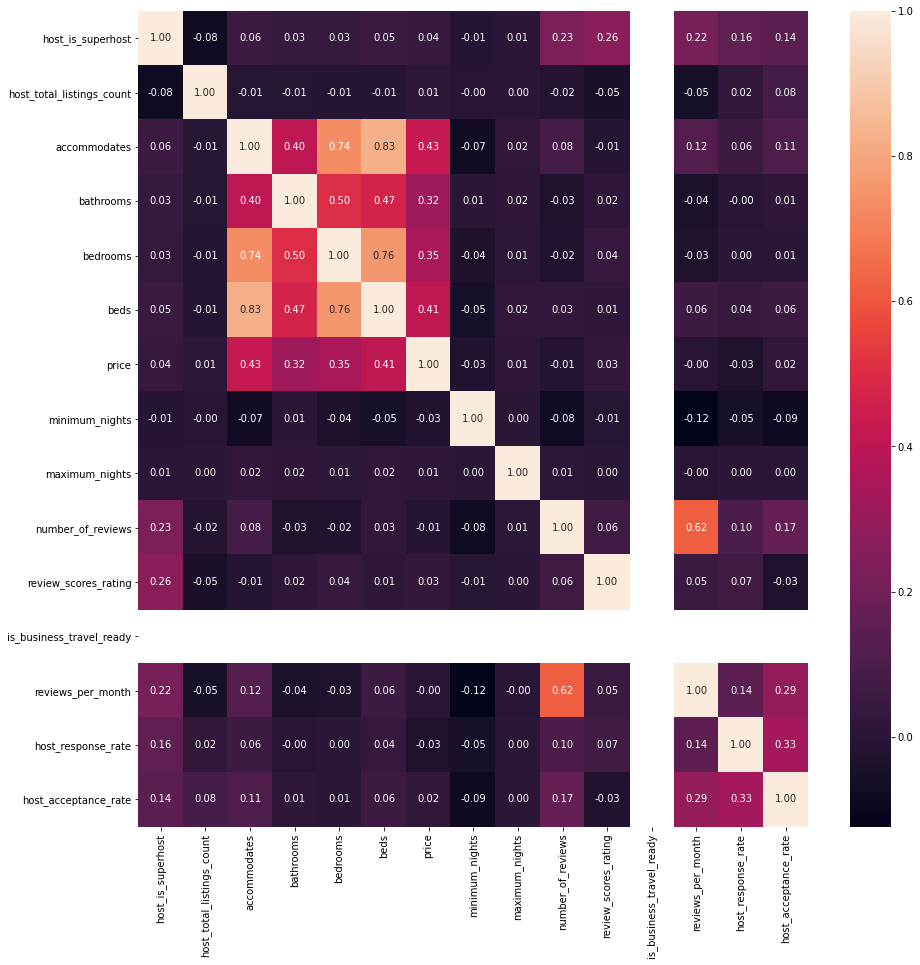

In [33]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(df_pred.corr(), annot=True, fmt=".2f", ax=ax);

It is clear that price has to do with number of beds, number of occupants,number of bedrooms which is intuitively correlated with square meters/feet. We dropped the square feet since most of the data is missing (around 98% of the data). Likely, having that would have given us better prediction.

Let's revisit the price distribution and look at the first 5 max values.

In [34]:
df_pred.sort_values('price',ascending=False).head()

,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,is_business_travel_ready,reviews_per_month,host_response_rate,host_acceptance_rate
2851,0,1.0,Rosemont-La Petite-Patrie,Entire home/apt,1,1.0,0.0,3.0,12333.0,2,14,17,87.000000,0,0.630000,33.0,63.0
12378,0,1.0,Mont-Royal,Entire home/apt,6,1.5,3.0,3.0,4199.0,31,365,5,100.000000,0,0.290000,100.0,74.0
13366,0,4.0,Dorval,Entire home/apt,16,6.0,8.0,9.0,3999.0,1,1125,2,100.000000,0,0.260000,60.0,96.0
20036,1,1.0,Le Plateau-Mont-Royal,Entire home/apt,2,2.0,2.0,2.0,3500.0,180,365,0,93.664855,0,1.727244,100.0,100.0
10152,1,13.0,Le Plateau-Mont-Royal,Entire home/apt,16,4.5,12.0,24.0,3500.0,1,1125,8,100.000000,0,0.360000,100.0,92.0


Will consider the 12333.0 an outlier as it is way far of, espicially given that it doesn't even look like a big home since it accomodates only 1 person and has 0 bedrooms. Not sure were the beds are fitted in. 

0.994 of the prices are below 1000


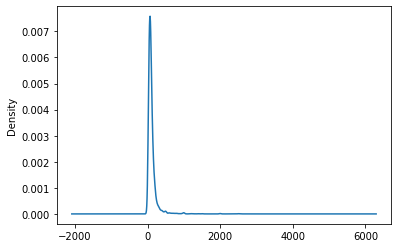

In [35]:
df_pred = df_pred[df_pred['price'] <  5000 ]
price_5000 = df_pred['price']
price_5000.plot.kde()
price_1000 = df_pred[df_pred['price'] <  1000 ]['price']
result = price_1000.count()/df_pred.shape[0]
print(f'{round(result,3)} of the prices are below 1000')

Still the distribution looks skewed. Since 99% of the cases we have prices below 1000$, we can look at the distribution again after filtering for that price.


In [36]:
df_pred.sort_values('price',ascending=True).head()

,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,is_business_travel_ready,reviews_per_month,host_response_rate,host_acceptance_rate
2908,0,2.0,Villeray-Saint-Michel-Parc-Extension,Entire home/apt,2,1.0,1.0,1.0,10.0,1,1125,31,93.000000,0,0.560000,95.022632,33.0
13991,0,1.0,Côte-des-Neiges-Notre-Dame-de-Grâce,Private room,2,1.0,1.0,1.0,13.0,2,1125,0,93.664855,0,1.727244,95.022632,50.0
14945,1,2.0,Côte-des-Neiges-Notre-Dame-de-Grâce,Private room,2,1.0,1.0,1.0,13.0,2,30,3,93.000000,0,0.320000,100.000000,85.0
14507,1,0.0,Ville-Marie,Private room,1,1.0,1.0,1.0,13.0,1,15,101,97.000000,0,9.440000,100.000000,99.0
7357,0,2.0,Le Plateau-Mont-Royal,Private room,2,1.0,1.0,1.0,14.0,4,1125,4,100.000000,0,0.130000,95.022632,50.0


An entire home for 10 dollars, that doesn't look right. Based on common sense, we can set the minimum price to be 25$ and update hte dataset.

In [37]:
df_pred = df_pred[df_pred['price'] >= 25 ]
df_pred.shape

(13477, 17)

We can zoom in further to each room type and look at each separately.

In [38]:
df_private_room = df_pred[df_pred['room_type'] == 'Private room']
df_entire_home = df_pred[df_pred['room_type'] == 'Entire home/apt']

In [39]:
print(f'Number of Entire homes: {df_entire_home.shape[0]}\n'
      f'Number of Private rooms: {df_private_room.shape[0]}')

Number of Entire homes: 10346
Number of Private rooms: 3131


The datasets are considered 'scarce' and cutting information any more from them is not necessarily the best solution. This  as well is not helpful in creating any predictive models as we probably need more datapoints. Refer to the scikit-learn roadmap here: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

Here we are going to simply get description of each listing type and look at the median instead of the average due to the skewness of the data.


In [40]:
df_private_room['price'].describe()

count    3131.000000
mean       60.408496
std        79.960383
min        25.000000
25%        35.000000
50%        45.000000
75%        61.000000
max      1500.000000
Name: price, dtype: float64

In [41]:
df_entire_home['price'].describe()

count    10346.000000
mean       138.040499
std        179.044137
min         25.000000
25%         71.000000
50%         99.000000
75%        149.000000
max       4199.000000
Name: price, dtype: float64

### Conclusion
Generally we can say that a private room would cost around 45 CAD and an entire house close to 100 CAD. Here, again, we are refering to the median rather than the average due to extreme data points.



## Summary
* More than half of the listings in Montréal can be found in 2 neigbhourhoods; Ville Marie and Plateau area.  Looking further on the top 4 neighbourhoods that account for more than 70% of the listings, they are all central in well connected areas by public transport.
* 70% of the listings are entire homes/apt and around 28% are private rooms.
* The median price for an Entire home/apt is around 100 CAD and around 45 CAD for a private room.

Couple of intuitive notes:
* There is not enough data points to start with to generate a meaningful model(around 13K after cleaning).
* The data points distribution is already skewed since more than 50% of them are in 2 main neighbourhoods and 70% of the room types are Entire home/apartment. 
* Location in that sense is a weak indicator since most of the data is concentrated in few central neighbourhoods(skewness of the distribution).
* The remaining strong candidates is area; this is intuitively related to accupancy which in turn is related to number of beds, bathrooms and how much the listing accomodates.